In [1]:
import os
import pickle
import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from scipy.stats import spearmanr

import nltk
from nltk.corpus import stopwords

import tensorflow as tf

import keras
import keras.backend as K

from keras.layers import Bidirectional
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

import re

import word2vecReader as w2v_reader

import matplotlib.pyplot as plt

import random as rn

from helpers import *

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(42)
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
config.gpu_options.allow_growth=True
sess = tf.Session(graph=tf.get_default_graph(),config=config)
K.set_session(sess)

stops = set(stopwords.words('english'))

pd.set_option('display.max_colwidth',150)

Using TensorFlow backend.


In [87]:
def plot_loss(history, show=True, title=None):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if title is None:
        plt.title('model loss')
    else:
        plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    if show:
        plt.show()
    
    
def pearson_loss(y_true, y_pred):
    numerator = -K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred)))
    denominator = ( K.sqrt(K.sum((K.square(y_true-K.mean(y_true))))) * K.sqrt(K.sum((K.square(y_pred-K.mean(y_pred)))))\
                   +K.epsilon() )
    return numerator/denominator


def get_model(embedding_matrix):
    model = Sequential()  
    model.add(Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights = [embedding_matrix],trainable=False))
    model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(150, activation='relu', dropout=0.2, kernel_initializer='he_normal',
                                 return_sequences=True)))
    model.add(Bidirectional(LSTM(80, dropout=0.2,kernel_initializer='he_normal')))
    model.add(Dense(50, activation='relu',kernel_initializer='he_normal'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=pearson_loss, optimizer="adam") 
    
    return model

In [3]:
word2vec_path = 'word_embeddings/word2vec/word2vec_twitter_model/word2vec_twitter_model.bin'
word2vec = w2v_reader.Word2Vec.load_word2vec_format(word2vec_path,
                                                    binary=True)

In [4]:
main_emotions = ['anger','fear','joy','sadness']

full_data={}
full_Y = {}
for emotion in main_emotions:
    full_data[emotion] = get_emotion_data(emotion)
    for data in full_data[emotion]:
        data['cleaned_text'] = data['text'].map(lambda s: text_to_wordlist(s, w2v = word2vec))
    full_Y[emotion] = [data['intensity'] for data in full_data[emotion]]

In [5]:
MAX_SEQUENCE_LENGTH = 30
tokenizer = Tokenizer(filters='"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(np.hstack([data['cleaned_text'] for data 
                                  in full_data['anger']+full_data['fear']+full_data['joy']+full_data['sadness']]))

In [6]:
X_sequences = {}
for emotion in main_emotions:
    X_sequences[emotion] = [pad_sequences(tokenizer.texts_to_sequences(data['cleaned_text'].values), 
                                          maxlen=MAX_SEQUENCE_LENGTH) for data in full_data[emotion]]

In [7]:
full_data['anger'][0].head(3)

,id,text,emotion,intensity,cleaned_text
0,10000,How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##,anger,0.938,how the fu k ! who the heck ! moved my fridge ! should i knock the landlord door #angry #mad ##
1,10001,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted,anger,0.896,so my indian uber driver just called someone the n word if i was not in a moving vehicle i would have jumped out #disgusted
2,10002,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice,anger,0.896,username i asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice


# Word2Vec

In [62]:
EMBEDDING_DIM = 400
MAX_SEQUENCE_LENGTH = 30

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))
bad_words = []
for word, i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec[word]
    else:
        bad_words.append(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 757


-------------------------------------
emotion:  anger


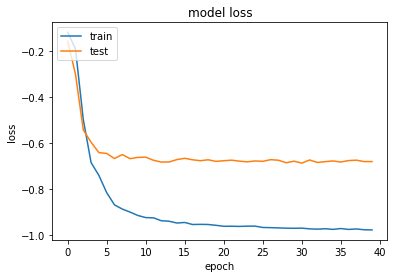

test score:  (0.69053281474131578, 0.67235703270916924, 0.53426563787479631, 0.50953263963631512)
-------------------------------------


-------------------------------------
emotion:  fear


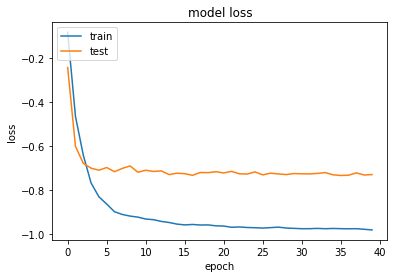

test score:  (0.73178354322582295, 0.71371169518951949, 0.59660818122380666, 0.5663293726844254)
-------------------------------------


-------------------------------------
emotion:  joy


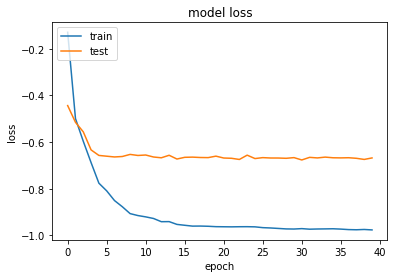

test score:  (0.68444660517513978, 0.68339967216339592, 0.47487582133793005, 0.47732458377989812)
-------------------------------------


-------------------------------------
emotion:  sadness


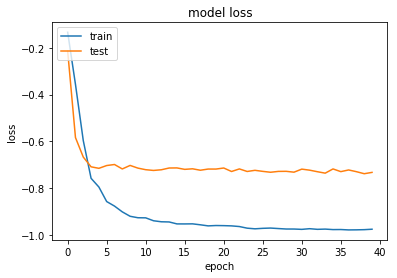

test score:  (0.73606742899856303, 0.72516266908400351, 0.57257575502277969, 0.54725753374212616)
-------------------------------------




In [88]:
simple_models = {}
for emotion in main_emotions:
    print('-------------------------------------')
    print('emotion: ', emotion)
    model = get_model(embedding_matrix)
    history = model.fit(X_sequences[emotion][0], full_Y[emotion][0],
                        epochs=40, verbose=0, validation_data=(X_sequences[emotion][2], full_Y[emotion][2]))
    simple_models[emotion] = {'model':model,'history':history}
    plot_loss(history)
    prediction =  model.predict(X_sequences[emotion][2]).reshape(-1)
    print('test score: ', evaluate(full_Y[emotion][2], prediction))
    print('-------------------------------------')
    print('\n')

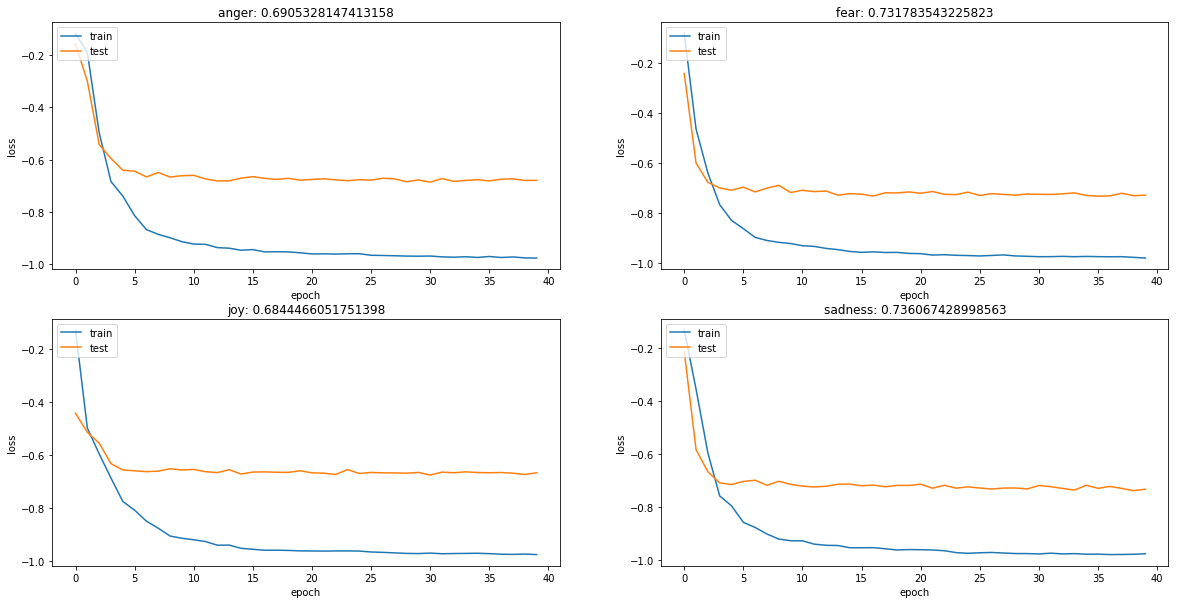

In [94]:
fig = plt.figure(figsize=(20, 10))
for i, emotion in enumerate(main_emotions):

    ax = fig.add_subplot(2, 2, i+1)
    prediction =  simple_models[emotion]['model'].predict(X_sequences[emotion][2]).reshape(-1)
    score = evaluate(full_Y[emotion][2], prediction)[0]
    title = '{emotion}: {test_score}'.format(emotion=emotion, test_score = score)
    plot_loss(simple_models[emotion]['history'],False,title)
plt.show()
    

# Word2Vec + ExtendedAfinn

In [95]:
extended_afinn = pickle.load( open( "features/extended_afinn.p", "rb" ) )

In [96]:
EMBEDDING_DIM = 401


embedding_matrix2 = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        extended_features = np.hstack([extended_afinn[word]]) if word in extended_afinn else 0
        embedding_matrix2[i] = np.hstack([word2vec[word], extended_features])


-------------------------------------
emotion:  anger


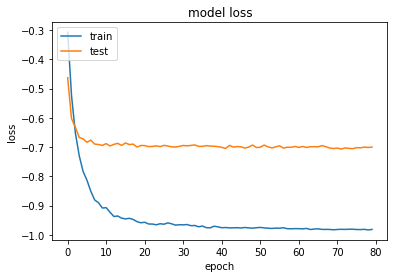

test score:  (0.71128692820233641, 0.68823959105206078, 0.55428330095210809, 0.52219268900491111)
-------------------------------------


-------------------------------------
emotion:  fear


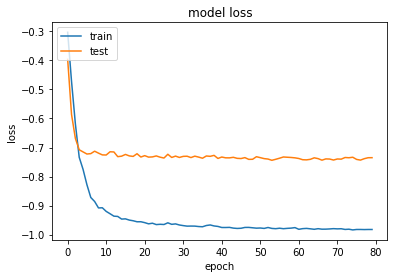

test score:  (0.73936124628738165, 0.72049497938300544, 0.5909748931883585, 0.57040122934773785)
-------------------------------------


-------------------------------------
emotion:  joy


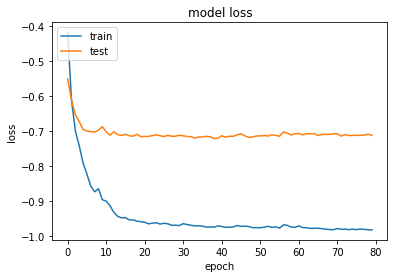

test score:  (0.72725092750035736, 0.72285477001910314, 0.47884385949989278, 0.49025580642106725)
-------------------------------------


-------------------------------------
emotion:  sadness


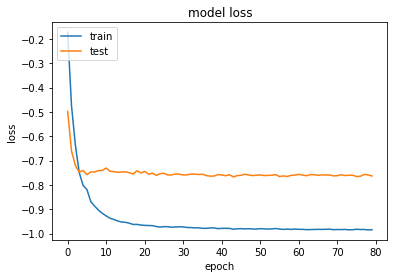

test score:  (0.76492370530167708, 0.76303529445654938, 0.56535823013346398, 0.54966184698516207)
-------------------------------------




In [97]:
afinn_models = {}
for emotion in main_emotions:
    print('-------------------------------------')
    print('emotion: ', emotion)
    model = get_model(embedding_matrix2)
    history = model.fit(np.vstack([X_sequences[emotion][0],X_sequences[emotion][1]]), np.hstack([full_Y[emotion][0],full_Y[emotion][1]]),
                        epochs=80, verbose=0, validation_data=(X_sequences[emotion][2], full_Y[emotion][2]))
    afinn_models[emotion] = {'model':model,'history':history}
    plot_loss(history)
    prediction =  model.predict(X_sequences[emotion][2]).reshape(-1)
    print('test score: ', evaluate(full_Y[emotion][2], prediction))
    print('-------------------------------------')
    print('\n')

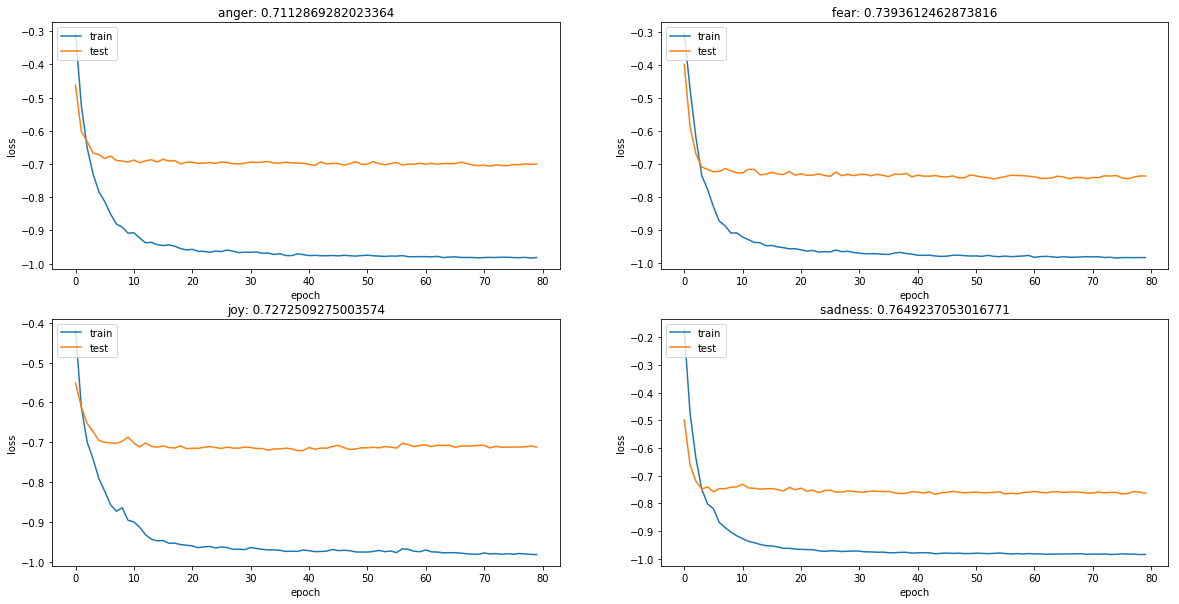

In [119]:
word2vec_afinn_scores = []
fig = plt.figure(figsize=(20, 10))
for i, emotion in enumerate(main_emotions):

    ax = fig.add_subplot(2, 2, i+1)
    prediction =  afinn_models[emotion]['model'].predict(X_sequences[emotion][2]).reshape(-1)
    score = evaluate(full_Y[emotion][2], prediction)
    title = '{emotion}: {test_score}'.format(emotion=emotion, test_score = score[0])
    plot_loss(afinn_models[emotion]['history'],False,title)
    word2vec_afinn_scores.append(score)
plt.show()
    

In [120]:
np.mean(word2vec_afinn_scores,axis=0)

array([ 0.7357057 ,  0.72365616,  0.54736507,  0.53312789])

In [87]:
# #не зашло
# scaled_word_emotions = pickle.load( open( "features/scaled_word_emotions.p", "rb" ) )
# scaled_extended_afinn = pickle.load( open( "features/scaled_extended_afinn.p", "rb" ) )

# lstm+gb average

In [103]:
gb_prediction={}
lstm_prediction={}
scores = {}
for emotion in main_emotions:
    gb_prediction[emotion] = pickle.load(open( "features/HE_AI_AFINN_GLOVE_TFIDF_gb_{emotion}.p".format(emotion=emotion),
                                              "rb" ))
    lstm_prediction[emotion] = afinn_models[emotion]['model'].predict(X_sequences[emotion][2]).reshape(-1)
    scores[emotion]=evaluate(full_Y[emotion][2],np.mean([gb_prediction[emotion],lstm_prediction[emotion]],axis=0))
    print('{0} test score: {1}'.format(emotion,scores[emotion]))

np.mean([scores[emotion] for emotion in main_emotions],axis=0)

anger test score: (0.72964462630772731, 0.70998318261230065, 0.56628688240470315, 0.53613200563175067)
fear test score: (0.75744605983811619, 0.74126968473640642, 0.61652872152914739, 0.58207835501853522)
joy test score: (0.74059459126028815, 0.73980656759718677, 0.50247381392713786, 0.50016711888857357)
sadness test score: (0.76826862500849002, 0.76405787146964421, 0.58103474289037027, 0.55539429741776825)


array([ 0.74898848,  0.73877933,  0.56658104,  0.54344294])

In [102]:
gb_prediction={}
lstm_prediction={}
scores = {}
for emotion in main_emotions:
    gb_prediction[emotion] = pickle.load(open( "features/HE_AI_AFINN_GLOVE_TFIDF_EXTENDED_gb_{emotion}.p"\
                                              .format(emotion=emotion),
                                              "rb" ))
    lstm_prediction[emotion] = afinn_models[emotion]['model'].predict(X_sequences[emotion][2]).reshape(-1)
    scores[emotion]=evaluate(full_Y[emotion][2],np.mean([gb_prediction[emotion],lstm_prediction[emotion]],axis=0))
    print('{0} test score: {1}'.format(emotion,scores[emotion]))
    
np.mean([scores[emotion] for emotion in main_emotions],axis=0)

anger test score: (0.74013314191334922, 0.72199095398980051, 0.57610071640811367, 0.54763195236341877)
fear test score: (0.76014011404321657, 0.74426693383446441, 0.6191753926805228, 0.58478102796238884)
joy test score: (0.74371867987023488, 0.74525594606886325, 0.50660556967851056, 0.506111432232213)
sadness test score: (0.77318133020875113, 0.76911058182431202, 0.56986110817270563, 0.54774100790718994)


array([ 0.75429332,  0.7451561 ,  0.5679357 ,  0.54656636])